In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: ignored

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/geiot

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from tqdm import tqdm
from torchvision import models,transforms
from PIL import Image
import cv2
import sys
import json
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import os
import os.path as osp
from glob import glob
import pandas as pd
import PIL

In [2]:
test_data=pd.read_csv("TeamB/input/test/test_anno.csv", index_col=0)
train_data=pd.read_csv("TeamB/input/train/train_anno.csv", index_col=0)
#test_data[test_data.Label!=5]
test_Genki_data=pd.read_csv("TeamB/input/test/test_anno(GENKI).csv", index_col=0).reset_index(drop=True)
train_Genki_data=pd.read_csv("TeamB/input/train/train_anno(GENKI).csv", index_col=0).reset_index(drop=True)
test_MTFL_data=pd.read_csv("TeamB/input/test/test_anno(MTFL).csv", index_col=0).reset_index(drop=True)
train_MTFL_data=pd.read_csv("TeamB/input/train/train_anno(MTFL).csv", index_col=0).reset_index(drop=True)

In [3]:
test_data=test_data[test_data.Label!=5].reset_index(drop=True)
train_data=train_data[train_data.Label!=5].reset_index(drop=True)
#1:ポジティブ、0:ネガティブ
print(test_data)
dict_map={ 0:0 , 1:0, 2:0 , 3:1 , 6:1 , 4:1}
test_data.Label=test_data.Label.map(dict_map)
train_data.Label=train_data.Label.map(dict_map)


                        imagePath  Label
0     TeamB/KDEF\AF03\AF03NES.JPG      4
1    TeamB/KDEF\BF25\BF25AFFL.JPG      0
2    TeamB/KDEF\AM16\AM16ANFL.JPG      1
3     TeamB/KDEF\BF02\BF02NES.JPG      4
4    TeamB/KDEF\BM18\BM18NEHR.JPG      4
..                            ...    ...
853  TeamB/KDEF\AM04\AM04NEHL.JPG      4
854  TeamB/KDEF\AM12\AM12DIFL.JPG      2
855   TeamB/KDEF\BF28\BF28HAS.JPG      3
856  TeamB/KDEF\BF13\BF13ANHL.JPG      1
857   TeamB/KDEF\AM18\AM18DIS.JPG      2

[858 rows x 2 columns]


In [4]:
test_data

,imagePath,Label
0,TeamB/KDEF\AF03\AF03NES.JPG,1
1,TeamB/KDEF\BF25\BF25AFFL.JPG,0
2,TeamB/KDEF\AM16\AM16ANFL.JPG,0
3,TeamB/KDEF\BF02\BF02NES.JPG,1
4,TeamB/KDEF\BM18\BM18NEHR.JPG,1
...,...,...
853,TeamB/KDEF\AM04\AM04NEHL.JPG,1
854,TeamB/KDEF\AM12\AM12DIFL.JPG,0
855,TeamB/KDEF\BF28\BF28HAS.JPG,1
856,TeamB/KDEF\BF13\BF13ANHL.JPG,0


In [5]:
test_data

,imagePath,Label
0,TeamB/KDEF\AF03\AF03NES.JPG,1
1,TeamB/KDEF\BF25\BF25AFFL.JPG,0
2,TeamB/KDEF\AM16\AM16ANFL.JPG,0
3,TeamB/KDEF\BF02\BF02NES.JPG,1
4,TeamB/KDEF\BM18\BM18NEHR.JPG,1
...,...,...
853,TeamB/KDEF\AM04\AM04NEHL.JPG,1
854,TeamB/KDEF\AM12\AM12DIFL.JPG,0
855,TeamB/KDEF\BF28\BF28HAS.JPG,1
856,TeamB/KDEF\BF13\BF13ANHL.JPG,0


#MTFLの成形

In [6]:
train_MTFL_data

,imagePath,Label
0,TeamB/MTFL\lfw_5590/Aaron_Eckhart_0001.jpg,2
1,TeamB/MTFL\lfw_5590/Aaron_Guiel_0001.jpg,1
2,TeamB/MTFL\lfw_5590/Aaron_Peirsol_0001.jpg,1
3,TeamB/MTFL\lfw_5590/Aaron_Pena_0001.jpg,2
4,TeamB/MTFL\lfw_5590/Aaron_Sorkin_0001.jpg,1
...,...,...
9995,TeamB/MTFL\net_7876/_60_929_0.jpg,1
9996,TeamB/MTFL\net_7876/_60_973_0.jpg,2
9997,TeamB/MTFL\net_7876/_60_979_0.jpg,1
9998,TeamB/MTFL\net_7876/_60_980_0.jpg,2


In [7]:
MTFL_dict={1:0,2:1}
train_MTFL_data.Label=train_MTFL_data.Label.map(MTFL_dict)
test_MTFL_data.Label=test_MTFL_data.Label.map(MTFL_dict)

In [8]:
train_data=pd.concat([train_data,train_Genki_data,train_MTFL_data],axis=0).reset_index(drop=True)
test_data=pd.concat([test_data,test_Genki_data,test_MTFL_data],axis=0).reset_index(drop=True)

In [9]:
len(test_data[test_data.Label==0])

2438

In [10]:
len(test_data)

4653

#DataSetクラスの作成

In [11]:
class MyDataset(data.Dataset):
  def __init__(self,dataFrame,transforms):
    """
    初期化
    Param
    ===================
    dataFrame:pd.dataFrame
    画像とアノテーションが含まれているdataFrame
    transforms:
    前処理
    """
    self.dataframe=dataFrame
    self.transforms=transforms
    
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    while (True):
      r_label=self.dataframe.Label[idx]
      img=cv2.imread(self.dataframe.imagePath[idx]) #Image.open(self.img_path[idx])
      if img.shape[2]==1:
        idx=random.randint(0,len(self))
      else:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        break
    if self.transforms:
      img=self.transforms(img)

    return img,r_label

# DataLoaderの実装

## 前処理

In [12]:
#TODO:Resizeのサイズ変更
traintransform=transforms.Compose([transforms.ToPILImage(),
                                   transforms.Resize((224,224)),
                                   transforms.RandomAffine(degrees=[-10, 10], translate=(0.1, 0.1), scale=(0.5, 1),interpolation=transforms.InterpolationMode.NEAREST),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]
                                   )
testtransform=transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((224,224)),transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [13]:
train_dataset=MyDataset(train_data,transforms=traintransform)

In [14]:
test_dataset=MyDataset(test_data,transforms=testtransform)

In [49]:
ttt=MyDataset(train_MTFL_data,transforms=traintransform)

In [50]:
ttt=data.DataLoader(ttt,batch_size=10,shuffle=True)

## DataLoaderの作成

In [15]:
train_dataLoader=data.DataLoader(train_dataset,batch_size=10,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


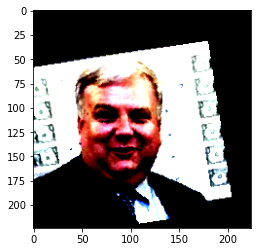

In [52]:
for datas,label in ttt:

  plt.imshow(datas[0].view(-1,224,224).detach().numpy().transpose(1, 2, 0))
  print(label[0])
  break

In [17]:
test_dataLoader=data.DataLoader(test_dataset,batch_size=10,shuffle=False)

# model ダウンロード

In [18]:
#学習済みモデルVGG16をロード

#VGG-16モデルのインスタンスを生成
net=models.resnet18(pretrained=False)
net.load_state_dict(torch.load('TeamB/modelParam/resnet18-f37072fd.pth'))


<All keys matched successfully>

In [19]:
#モデル追加
save_path='weight_fine_tuning_2way_extend.pth'
#addmoduleだとforwardの定義がないためうまくいかない
net=nn.Sequential(net,nn.Linear(in_features=1000,out_features=2))
#if os.path.exists(save_path):
#  net.load_state_dict(torch.load(save_path))
net.train()
#net.add_module("last_fc",nn.Linear(1000,101,bias=False))

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

# 損失関数と最適化手法

In [20]:
criterion=nn.CrossEntropyLoss()

In [21]:
#このようにして配列に挿入した辞書函数使って、モデルパラメータごとにオプティマイザーのパラメーターを設定することができる
optimizer=optim.Adam(net.parameters())
#optimizer=optim.Adam(net.parameters(),lr=0.001)

In [22]:
def tarin_model(net,dataloaders_dict,criterion,optimizer,num_epochs):
  #初期設定
  #GPUが使えるかを確認する
  device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print('使用でヴァイス:',device)
  #ネットワークをGPUへ
  net=net.to(device)
  #ネットワークがある程度固定(epochごとにネットワーク構造や損失関数が変わったりしない)の場合に高速化させる
  torch.backends.cudnn.benchmark=True
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1,num_epochs))
    print('__________')
    for phase in ['train','test']:
      if phase=='train':
        net.train()
      else:
        net.eval()
      epoch_loss=0.0
      epoch_corrects=0
      for inputs,labels in tqdm(data_loaders_dict[phase]):
        #入力をGPUへ
        inputs=inputs.to(device)
        labels=labels.to(device)
        #optimizerの初期化
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase=='train'):
          outputs=net(inputs)
          #print("output",outputs.shape)
          #print("labels",torch.max(labels,1)[1])
          #print(outputs)
          #print(labels)
          loss=criterion(outputs,labels)
          _,preds=torch.max(outputs,1)
          if phase=='train':
            loss.backward()
            optimizer.step()
          #tensor.item()はTensor内部の数値をPythonの数字で出力.戻り値はintやfloat
          epoch_loss+=loss.item()*inputs.size(0)
          #Tensor.dataはTensorのコピーを作成する。戻り値もTensor
          epoch_corrects+=torch.sum(preds==labels.data)
      epoch_loss=epoch_loss/len(data_loaders_dict[phase].dataset)
      epoch_acc=epoch_corrects.double()/len(data_loaders_dict[phase].dataset)
      net=net.to("cpu")
      torch.save(net.state_dict(),save_path)
      net=net.to(device)
      print('{} Loss: {:4f} Acc: {:4f}'.format(phase,epoch_loss,epoch_acc))
      print("output",outputs.shape)

In [23]:
data_loaders_dict={"train":train_dataLoader,"test":test_dataLoader}

In [24]:
num=10
tarin_model(net,data_loaders_dict,criterion,optimizer,num_epochs=num)

使用でヴァイス: cuda
Epoch 1/10
__________


  0%|                                                                                         | 0/1655 [00:00<?, ?it/s]E:\Anaconda\envs\AIProj\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [02:54<00:00,  9.49it/s]


train Loss: 0.726808 Acc: 0.511880
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:31<00:00, 14.92it/s]


test Loss: 0.749202 Acc: 0.523963
output torch.Size([3, 2])
Epoch 2/10
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [02:50<00:00,  9.69it/s]


train Loss: 0.706732 Acc: 0.508313
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:30<00:00, 15.09it/s]


test Loss: 0.714981 Acc: 0.523963
output torch.Size([3, 2])
Epoch 3/10
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [02:46<00:00,  9.95it/s]


train Loss: 0.704209 Acc: 0.515930
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:30<00:00, 15.24it/s]


test Loss: 0.693670 Acc: 0.528906
output torch.Size([3, 2])
Epoch 4/10
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [02:49<00:00,  9.75it/s]


train Loss: 0.701008 Acc: 0.513210
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:29<00:00, 15.88it/s]


test Loss: 0.694415 Acc: 0.533634
output torch.Size([3, 2])
Epoch 5/10
__________


100%|██████████████████████████████████████████████████████████████████████████████| 1655/1655 [02:40<00:00, 10.29it/s]


train Loss: 0.698475 Acc: 0.512605
output torch.Size([1, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 466/466 [00:29<00:00, 16.06it/s]


test Loss: 0.809604 Acc: 0.523963
output torch.Size([3, 2])
Epoch 6/10
__________


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1570/1655 [02:30<00:08, 10.41it/s]


KeyboardInterrupt: ignored

In [25]:
dat

NameError: ignored